In [4]:
%load_ext autoreload
%autoreload 2
import sklearn
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
#from viz import viz
from bokeh.plotting import figure, show, output_notebook, output_file, save
#from functions import merge_data
from sklearn.model_selection import RandomizedSearchCV
#import load_data

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# 'deaths' and 'cases' contain the time-series of the outbreak
df = load_data.load_county_level()
df = df.sort_values(load_data.outcome_deaths, ascending=False)
outcome_cases = 'tot_cases'
outcome_deaths = 'tot_deaths'
important_vars = load_data.important_keys(df)

NameError: name 'load_data' is not defined

In [324]:
def sum_lists(list_of_lists):
    arr = np.array(list(list_of_lists))
    sum_arr = np.sum(arr,0)
    return list(sum_arr)

In [326]:
# # Aggregate by State
# state_deaths_df = df.groupby('StateNameAbbreviation').deaths.agg(sum_lists).to_frame()
# state_cases_df = df.groupby('StateNameAbbreviation').cases.agg(sum_lists).to_frame()
# df =  pd.concat([state_cases_df,state_deaths_df],axis =1 )

42
64
119
507
910
118.61635944700461
16.0


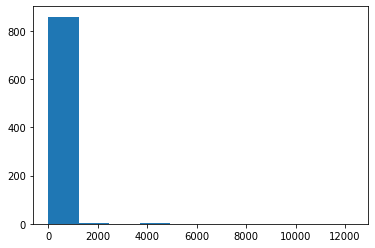

In [327]:
# This is investigating the number of cases associated with non-zero deaths in a county
_deaths = list(df['deaths'])
_cases = list(df['cases'])
total_points = []

cases_for_death = []
for i in range(len(df)):
    for j,d in enumerate(_deaths[i]):
        if d > 0:

            cases_for_death.append(_cases[i][j])
            if _cases[i][j] == 0:
                print(i)
                
plt.hist(cases_for_death)
print(np.mean(cases_for_death))
print(np.quantile(cases_for_death,.5))

1204


(array([56., 25., 26., 14.,  7., 10.,  4.,  9.,  3.,  1.,  1.,  6.,  2.,
         4.,  6.,  1.,  0.,  2.,  2.,  0.,  2.,  0.,  0.,  2.,  1.,  1.,
         1.,  2.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,
         1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 21.  ,  30.01,  39.02,  48.03,  57.04,  66.05,  75.06,  84.07,
         93.08, 102.09, 111.1 , 120.11, 129.12, 138.13, 147.14, 156.15,
        165.16, 174.17, 183.18, 192.19, 201.2 , 210.21, 219.22, 228.23,
        237.24, 246.25, 255.26, 264.27, 273.28, 282.29, 291.3 , 300.31,
        309.32, 318.33, 327.34, 336.35, 345.36, 354.37, 363.38, 372.39,
        381.4 , 390.41, 399.42, 408.43, 417.44, 426.45, 435.46, 444.47,
  

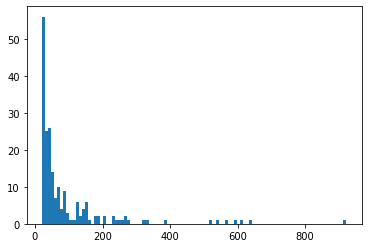

In [328]:
# Distribution of the maximum number of cases
_cases = list(df['cases'])

max_cases = []
for i in range(len(df)):
    max_cases.append(max(_cases[i]))
    
print(sum([v >0 for v in max_cases]))
# plt.hist(max_cases)

# print(sum([v >0 for v in max_cases]))
plt.hist([v for v in max_cases if v > 20 and v < 1000],bins = 100)


In [329]:
print(sum([v > 50 for v in max_cases]))


94


In [330]:
np.quantile(max_cases,1)

12305

186


(array([54.,  4.,  2.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.]),
 array([  2. ,   6.1,  10.2,  14.3,  18.4,  22.5,  26.6,  30.7,  34.8,
         38.9,  43. ,  47.1,  51.2,  55.3,  59.4,  63.5,  67.6,  71.7,
         75.8,  79.9,  84. ,  88.1,  92.2,  96.3, 100.4, 104.5, 108.6,
        112.7, 116.8, 120.9, 125. ]),
 <a list of 30 Patch objects>)

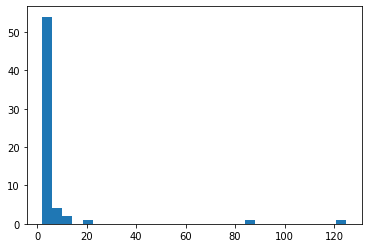

In [331]:
# Distribution of the maximum number of cases
_deaths = list(df['deaths'])

max_deaths = []
for i in range(len(df)):
    max_deaths.append(max(_deaths[i]))
    
print(sum([v >0 for v in max_deaths]))
# plt.hist(max_cases)

# print(sum([v >0 for v in max_cases]))
plt.hist([v for v in max_deaths if v > 1],bins=30)

In [333]:
np.quantile(max_deaths,.9)

1.0

### Clean data

In [334]:
# Remove rows with zero cases
max_cases = [max(v) for v in df['cases']]
df['max_cases'] = max_cases
df_with_cases = df[df['max_cases'] > 0]


In [335]:
# Shuffle data
shuffled_df = df_with_cases.sample(frac=1)
# Break into train test (random k-fold cross val on the training set is done to pick hyperparams)
train_ratio, val_ratio, test_ratio = .75,0,.25


train_df = shuffled_df[0:int(train_ratio*len(shuffled_df))]
# val_df = shuffled_df[int(train_ratio*len(shuffled_df)):int(val_ratio*len(shuffled_df))+int(train_ratio*len(shuffled_df))]
test_df = shuffled_df[int(train_ratio*len(shuffled_df))+int(val_ratio*len(shuffled_df)):]



In [336]:
def make_auto_regressive_dataset(df,autoreg_window,log=True,deaths=True,cases=False,predict_deaths=True):
    """
    Make an autoregressive dataset that takes in a dataframe and a history window to predict number of deaths
    for a given day given a history of autoreg_window days before it
    log: take logarithm of values for features and predictions
    deaths: use number of previous deaths as features
    cases: use number of previous cases as features
    predict_deaths: predict deaths otherwise predict cases
    """

    assert (deaths == True or cases == True)
    feature_array = []
    ys = []
    _cases = list(df['cases'])
    _deaths = list(df['deaths'])
    for i in range(len(_cases)):
        for j in range(len(_cases[i])-(autoreg_window+1)):
            if predict_deaths:
                contains_event = sum(_deaths[i][j:j+autoreg_window+1]) > 0
            else:
                contains_event = sum(_cases[i][j:j+autoreg_window+1]) > 0
            if contains_event > 0:
                cases_window = _cases[i][j:j+autoreg_window]
                if log:
                    cases_window = [np.log(v+1) for v in cases_window ]
                deaths_window = _deaths[i][j:j+autoreg_window]
                if log:
                    deaths_window = [np.log(v+1) for v in deaths_window]
                if predict_deaths:
                    y_val = _deaths[i][j+autoreg_window+1]
                else:
                    y_val = _cases[i][j+autoreg_window+1]
                if log:
                    y_val = np.log(y_val+1)
                features = []
                if deaths == True:
                    features.extend(deaths_window)
                if cases == True:
                    features.extend(cases_window)
                feature_array.append(features)
                ys.append(y_val)
    return feature_array, ys
            
    

In [337]:
def evaluate_model(model,eval_pair, metric, exponentiate=False):
    """
    Model: sklearn model
    Eval pair: (x,y)
    metric: sklearn metric
    exponentiate: exponentiate model predictions?
    """
    predictions = model.predict(eval_pair[0])
    y_val = eval_pair[1]
    if exponentiate:
        predictions = [np.exp(p) for p in predictions]
        y_val = [np.exp(y) for y in y_val]
    return predictions, metric(predictions,y_val)
    


    
    

In [338]:
model = sklearn.neighbors.KNeighborsRegressor()
param_dist ={
    'n_neighbors': [2,4,8,16],
    'weights': ['uniform','distance'],
    'p': [1,2,4]
}

# model = RandomForestRegressor()
# param_dist ={
#     'n_estimators': [50,100,200,400,1000]
# }
# Number of randomly sampled hyperparams
n_iter = 20
metric = sklearn.metrics.mean_squared_error
# n_jobs = number of cores to parallelize across
random_search = RandomizedSearchCV(model, param_distributions=param_dist,
                                   n_iter=n_iter,n_jobs = 8)
predict_deaths = False



auto_reg_windows = [1,2,4,8]
best_window = None
best_loss = None
for w in auto_reg_windows:
    log = False
    x_train, y_train = make_auto_regressive_dataset(train_df,w,log=log,predict_deaths=predict_deaths)
    x_test, y_test = make_auto_regressive_dataset(test_df,w,log=log,predict_deaths=predict_deaths)
    random_search.fit(x_train,y_train)
    window_loss = random_search.best_score_
    if best_loss is None:
        best_window = w
        best_loss = window_loss
    elif window_loss < best_loss:
        best_window = w
        best_score = loss
   


x_train, y_train = make_auto_regressive_dataset(train_df,best_window,log=log)
x_test, y_test = make_auto_regressive_dataset(test_df,best_window,log=log)
random_search.fit(x_train,y_train)


preds, loss = evaluate_model(random_search,(x_test,y_test),metric,exponentiate=True)
     
        

# model.fit(x_train,y_train)

In [339]:
random_search.best_params_

{'weights': 'uniform', 'p': 2, 'n_neighbors': 8}

In [340]:
best_window

1

In [341]:
loss

330797.74422408896

In [353]:
# WARNING: does not yet supported number of previous cases as feature
def get_auto_reg_predictions(model,row,window,teacher_forcing=True,exponentiate=False,predict_deaths=True):
    if predict_deaths:
        key = 'deaths'
    else:
        key = 'cases'
        
    deaths = row[key]
    predictions = [0]
    if teacher_forcing:
        for i in range(len(deaths)-(window)):
            x = deaths[i:i+window]
            cur_prediction = model.predict([x])
            if exponentiate:
                cur_prediction = np.exp(cur_prediction)
            predictions.append(cur_prediction)
    else:
        raise NotImplementedError
    return predictions
    
def plot_prediction(model,row,window,exponentiate=False,predict_deaths=True):
    """
    Plots model predictions vs actual
    row: dataframe row
    window: autoregressive window size
    """
    if predict_deaths:
        key = 'deaths'
    else:
        key = 'cases'
    
    model_predictions = get_auto_reg_predictions(model,row,window,exponentiate,predict_deaths=predict_deaths)
    model_predictions = [float(v) for v in model_predictions]
    print(model_predictions)
    for i,val in enumerate(row[key]):
        if val > 0:
            start_point = i
            break
    plt.plot(row[key][start_point:], label=key)

    
    plt.plot(model_predictions[start_point:],label='predictions')
    print(model_predictions[start_point:])
    plt.fill_between(list(range(len(row[key][start_point:]))),row[key][start_point:],model_predictions[start_point:])
    plt.legend()
    plt.show()
    
    
    
    
    

[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.625, 0.625, 3.375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.625]
[1.0, 0.625, 0.625, 3.375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.625]


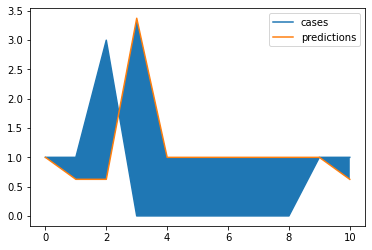

[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.625, 2.625, 2.625, 2.625, 3.375, 6.25, 6.25, 7.125, 7.125, 6.25, 10.75, 16.5, 16.5, 19.75, 21.75, 37.375]
[1.0, 2.625, 2.625, 2.625, 2.625, 3.375, 6.25, 6.25, 7.125, 7.125, 6.25, 10.75, 16.5, 16.5, 19.75, 21.75, 37.375]


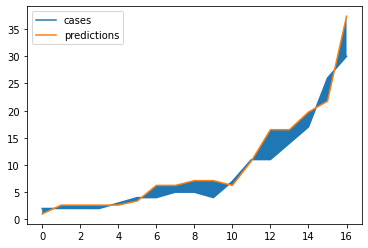

[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 16.25, 16.25, 16.25, 16.25, 21.75, 40.0, 42.125, 46.25, 45.75, 45.75, 63.125, 67.875, 67.875, 67.875]
[1.0, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 16.25, 16.25, 16.25, 16.25, 21.75, 40.0, 42.125, 46.25, 45.75, 45.75, 63.125, 67.875, 67.875, 67.875]


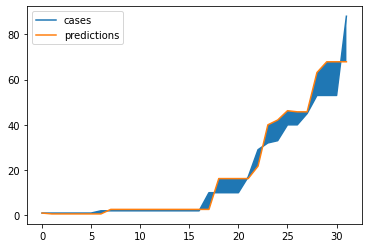

[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.625]
[1.0, 0.625]


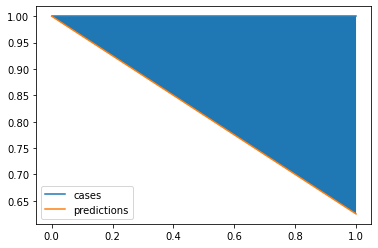

[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 8.75, 8.75, 8.75, 10.75, 33.5, 63.125, 63.125, 67.875]
[1.0, 8.75, 8.75, 8.75, 10.75, 33.5, 63.125, 63.125, 67.875]


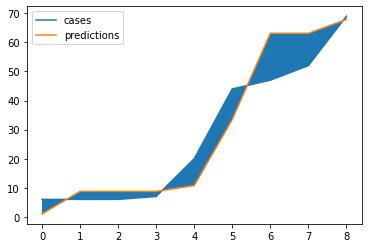

[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.625, 8.75, 10.75, 18.875, 37.375, 63.125, 73.375, 73.375, 73.375, 73.375]
[1.0, 2.625, 8.75, 10.75, 18.875, 37.375, 63.125, 73.375, 73.375, 73.375, 73.375]


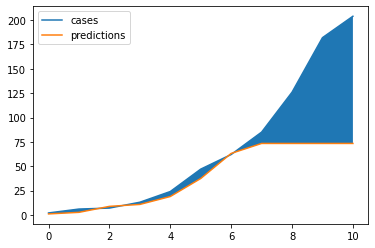

[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 3.375, 3.375, 6.25, 6.25, 6.25, 6.25, 8.75, 16.5, 16.25]
[1.0, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 3.375, 3.375, 6.25, 6.25, 6.25, 6.25, 8.75, 16.5, 16.25]


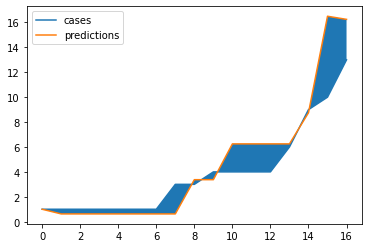

[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.625, 0.625, 0.625, 8.75, 11.25, 18.875, 19.75, 21.75, 35.25, 73.375, 73.375, 73.375, 73.375]
[1.0, 0.625, 0.625, 0.625, 8.75, 11.25, 18.875, 19.75, 21.75, 35.25, 73.375, 73.375, 73.375, 73.375]


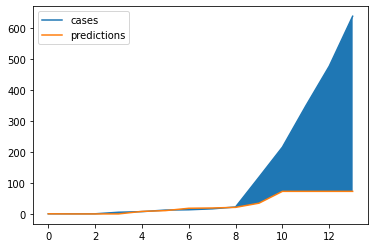

[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.625, 2.625, 10.75, 10.75]
[1.0, 0.625, 2.625, 10.75, 10.75]


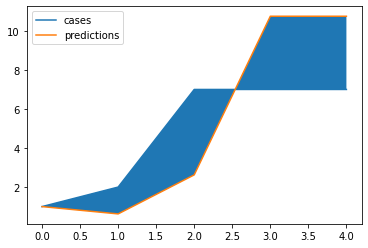

[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.625, 0.625, 3.375, 1.0, 1.0, 1.0, 0.625, 3.375, 3.375, 7.125]
[1.0, 0.625, 0.625, 3.375, 1.0, 1.0, 1.0, 0.625, 3.375, 3.375, 7.125]


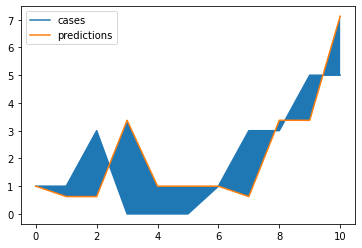

In [354]:
for i in range(len(test_df)):
    row = test_df.iloc[i]
    if max(row['deaths'][:-1]) > 1:
        plot_prediction(random_search,row,best_window,exponentiate=True,predict_deaths=predict_deaths)

## Predict deaths from cases

In [359]:
def create_case_to_death_data(df):
    _cases = []
    _deaths = []
    _y_deaths = []
    for i in range(len(df)):
        row = df.iloc[i]
        deaths = row['deaths']
        cases = row['cases']
        for j in range(len(deaths)):
            if cases[j] > 0:
                _cases.append(cases[j])
                if j == 0:
                    _deaths.append(0)
                else:
                    _deaths.append(deaths[j-1])

                _y_deaths.append(deaths[j])
    return (_cases,_deaths,_y_deaths)

train_cases, train_deaths, train_y_deaths = create_case_to_death_data(train_df)
test_cases, test_deaths, test_y_deaths = create_case_to_death_data(test_df)


In [363]:
model = RandomForestRegressor()
param_dist ={
    'n_estimators': [50,100,200,400,1000]
}

metric = sklearn.metrics.mean_squared_error
# n_jobs = number of cores to parallelize across
deaths_random_search = RandomizedSearchCV(model, param_distributions=param_dist,
                                   n_iter=n_iter,n_jobs = 8)

deaths_random_search.fit(list(zip(train_cases,train_deaths)),train_y_deaths)

/Users/nick/anaconda2/envs/covid/lib/python3.6/site-packages/sklearn/model_selection/_search.py:281: UserWarning:

The total space of parameters 5 is smaller than n_iter=20. Running 5 iterations. For exhaustive searches, use GridSearchCV.



RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                           

In [369]:
pred_deaths = deaths_random_search.predict(list(zip(test_cases,test_deaths)))

In [370]:
metric(pred_deaths,test_y_deaths)

0.04686110315167603

In [ ]:
row = df.iloc[0]

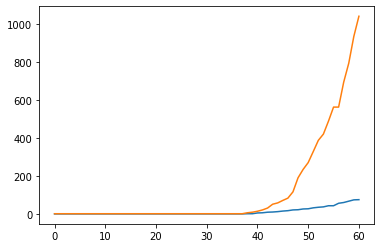

In [ ]:
plt.plot(row['deaths'], label='deaths')
plt.plot(row['cases'], label='cases')
plt.legend()
plt.show()